In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import copy
from tqdm import trange
from torchsummary import summary
from torch.nn.parameter import Parameter
from torch.optim import SGD, Optimizer
from typing import List

import torchvision
import torchvision.transforms as transforms

In [2]:
# Hyperparameters for training
num_rounds = 50
local_rounds = 10
num_clients = 10  # Total number of clients
num_selected = 10  # Number of selected clients per round
local_bs = 10
lr = 0.001
num_channels = 3
num_classes = 10
test_bs = 128
gpu = 1
gamma = 0.1
milestones = [0.5 * num_rounds, 0.75 * num_rounds]

momentum = 0.9
weight_decay = 0.00001
mu = 0.01

In [3]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda', index=4)

In [5]:
#ResNet9
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [6]:
class ResNet9(nn.Module):
    def __init__(
            self, 
            in_channels, 
            num_classes):
        super(ResNet9, self).__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512,num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [7]:
class CIFAR10_truncated(Dataset):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = datasets.CIFAR10(self.root, self.train, self.transform, self.target_transform, self.download)

        data = np.array(cifar_dataobj.data)
        target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

In [8]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.targets = dataset.targets
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

In [9]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])])

In [10]:
# CIFAR10 Data loading
train_dataset = CIFAR10_truncated('./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR10_truncated('./data', train=False, download=True, transform=transform_test)

X_train, y_train = train_dataset.data, train_dataset.target
X_test, y_test = test_dataset.data, test_dataset.target

Files already downloaded and verified
Files already downloaded and verified


In [11]:
def record_net_data_stats(y_train, net_dataidx_map):

    net_cls_counts = {}

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp

    #print('Data statistics: %s' % str(net_cls_counts))

    return net_cls_counts

In [12]:
# for IID case
def generate_iid_cifar(X_train,y_train, num_of_clients):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param n_nets: Number of clients
    :return: Tuple containing train and test datasets, data index map for each client, and train data class counts
    """
    
    n_train = X_train.shape[0]

    # Shuffle and partition the data
    idxs = np.arange(n_train)
    np.random.shuffle(idxs)

    net_data_idx_map = {}
    batch_idxs = np.array_split(idxs, num_of_clients)

    for i in range(num_of_clients):
        net_data_idx_map[i] = batch_idxs[i]

    traindata_class_counts = record_net_data_stats(y_train, net_data_idx_map)

    return net_data_idx_map, traindata_class_counts

In [13]:
def generate_noniid_cifar(X_train,y_train, num_of_clients, alpha=0.5):
    """
    Sample non I.I.D. client data from CIFAR10 dataset
    :param dataset: 
    :param num_users: 
    :return: 
    """

    n_train = len(X_train.shape)

    min_size = 0
    K = 10
    N = len(y_train)
    net_dataidx_map = {}

    while min_size < 10:
        idx_batch = [[] for _ in range(num_of_clients)]
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = np.random.dirichlet(np.repeat(alpha, num_of_clients))
            ## Balance
            proportions = np.array([p*(len(idx_j)<N/num_of_clients) for p,idx_j in zip(proportions,idx_batch)])
            proportions = proportions/proportions.sum()
            proportions = (np.cumsum(proportions)*len(idx_k)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_batch,np.split(idx_k,proportions))]
            min_size = min([len(idx_j) for idx_j in idx_batch])

    for j in range(num_of_clients):
        np.random.shuffle(idx_batch[j])
        net_dataidx_map[j] = idx_batch[j]
    traindata_class_counts = record_net_data_stats(y_train, net_dataidx_map)

    return net_dataidx_map, traindata_class_counts

In [14]:
noniid_dataidx_map, noniid_traindata_cls_counts = generate_noniid_cifar(X_train,y_train, num_clients)

In [15]:
# from torchviz import make_dot

# # Sample input to model for visualization
# sample_input = torch.randn(1, num_channels, 32, 32).to(device)
# model_vis = LeNet(num_classes).to(device)

# # Visualize the model
# model_dot = make_dot(global_model(sample_input), params=dict(list(global_model.named_parameters())))
# model_dot.render("model_architecture", format="png")  # Saves the diagram as PNG

In [17]:
# Client training function
def client_train(global_mod:nn.Module, net: nn.Module,
    loader: DataLoader,
    device: torch.device,
    local_rounds: int,
    proximal_mu: float,
    learning_rate: float,
    momentum: float,
    weight_decay: float):
    
    epoch_loss = []
    epoch_acc = []
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(
        net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay
    )
    global_params = [param.detach().clone() for param in global_mod.parameters()]
    net.train()
    for _ in range(local_rounds):
        batch_loss = []
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            proximal_term = 0.0
            for param, global_param in zip(net.parameters(), global_params):
                proximal_term += torch.norm(param - global_param) ** 2
            loss += (proximal_mu / 2) * proximal_term
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())

            _, pred = torch.max(output, dim=1)
            correct_train = pred.eq(target.data.view_as(pred))
            accuracy_train = torch.mean(correct_train.type(torch.FloatTensor))
            epoch_acc.append(accuracy_train.item())

        epoch_loss.append(sum(batch_loss) / len(batch_loss))
    return net.state_dict(), sum(epoch_loss) / len(epoch_loss), sum(epoch_acc) / len(epoch_acc)

In [18]:
# 'FedAvg' aggregation
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

In [19]:
# Evaluate on Test dataset
def evaluate(global_model, datatest, test_bs, device):
    global_model.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=test_bs)
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            log_probs = global_model(data)
            # sum up batch loss
            test_loss += F.cross_entropy(log_probs,
                                         target, reduction='sum').item()
            # get the index of the max log-probability
            y_pred = log_probs.data.max(1, keepdim=True)[1]
            correct += y_pred.eq(target.data.view_as(y_pred)
                                 ).long().cpu().sum()

        test_loss /= len(data_loader.dataset)
        accuracy = 100.00 * correct.item() / len(data_loader.dataset)
    return accuracy, test_loss

In [20]:
# Initialize and synchronize models###
global_model = ResNet9(
    in_channels=num_channels, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

In [21]:
clients_models = {i: ResNet9(in_channels=num_channels, num_classes=num_classes).to(device) for i in range(num_clients)}
optimizers={}
for key, model in clients_models.items():
   optimizers[key] =  torch.optim.Adam(model.parameters(), lr=lr)

schedulers={}
for key, optimizer in optimizers.items():
   schedulers[key] =  torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [22]:
clients_models.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [23]:
# Evaluation on test dataset for each round
cur_auc, test_loss = evaluate(
   global_model, test_dataset, test_bs, device)
print(f'Round Test, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')

Round Test, Test Loss: 2.3054, Test Accuracy: 8.83%


In [24]:
# Evaluation on test dataset for each round
cur_auc, test_loss = evaluate(
    clients_models[0], test_dataset, test_bs, device)
print(f'Round Test, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')

Round Test, Test Loss: 2.3042, Test Accuracy: 7.57%


In [25]:
for model in clients_models.values():
  model.load_state_dict(global_model.state_dict())

In [26]:
# Evaluation on test dataset for each round
cur_auc, test_loss = evaluate(
    clients_models[0], test_dataset, test_bs, device)
print(f'Round Test, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')

Round Test, Test Loss: 2.3054, Test Accuracy: 8.83%


In [27]:
global_model.train()

best_auc = 0
best_round = 0
loss_train = []
loss_test = []
acc_train = []
acc_test= []
clients_selected = {}
# selected_clients = np.random.choice(range(num_clients), num_selected, replace=False)

# local_indices = generate_iid_cifar(train_dataset, num_clients)

for round in range(num_rounds):
    local_weights, local_losses, local_acc = [], [], []

    # Select a subset of clients to train this round
    # for selected_client in selected_clients:
    #     print("clients sleected "+str(selected_client))
    selected_clients = list(np.random.choice(range(num_clients), num_selected, replace=False))
    clients_selected[round] = selected_clients
    for i in trange(num_selected):
        local_loader = DataLoader(CIFAR10_truncated(
        './data', dataidxs=noniid_dataidx_map[i], train=True, transform=transform_train), batch_size=local_bs, shuffle=True)

        # Train on local data
        # w, loss, acc = client_train(
        #     clients_models[i], local_loader, optimizers[i], schedulers[i], criterion, local_rounds)
        w, loss, acc = client_train(global_model, clients_models[i], local_loader, device, local_rounds, mu, lr, momentum, weight_decay)

        # Collect local model weights
        local_weights.append(w)
        local_losses.append(loss)
        local_acc.append(acc)

    # Aggregate local weights to update global model
    global_weights = FedAvg(local_weights)
        # with open('readme.txt', 'a') as f:
        #     f.write('Weights and bias of client '+str(client)+': \n'+str(w))
        # print(f"Local weight of {client} is: ", w)
    
    # copy weight to global model
    global_model.load_state_dict(global_weights)
    for model in clients_models.values():
        model.load_state_dict(global_model.state_dict())

    # Calulate loss
    loss_avg = sum(local_losses) / len(local_losses)
    # print('Round {:3d}, Train loss {:.3f}'.format(round, loss_avg))
    loss_train.append(loss_avg)
    acc_train.append(100 * sum(local_acc) / len(local_acc))

    # Evaluation on test dataset for each round
    cur_auc, test_loss = evaluate(
        global_model, test_dataset, test_bs, device)
    loss_test.append(test_loss)
    acc_test.append(cur_auc)
    print(f'Round {round+1}, Train loss: {loss_avg:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {cur_auc:.2f}%')


100%|██████████| 10/10 [18:56<00:00, 113.66s/it]


Round 1, Train loss: 1.5713, Test Loss: 2.4650, Test Accuracy: 11.42%


100%|██████████| 10/10 [23:26<00:00, 140.65s/it]


Round 2, Train loss: 1.2178, Test Loss: 1.8194, Test Accuracy: 34.24%


100%|██████████| 10/10 [20:10<00:00, 121.03s/it]


Round 3, Train loss: 0.9047, Test Loss: 1.4026, Test Accuracy: 51.78%


100%|██████████| 10/10 [09:42<00:00, 58.27s/it]


Round 4, Train loss: 0.7006, Test Loss: 1.1437, Test Accuracy: 63.17%


100%|██████████| 10/10 [08:44<00:00, 52.45s/it]


Round 5, Train loss: 0.5738, Test Loss: 0.8859, Test Accuracy: 71.37%


100%|██████████| 10/10 [08:39<00:00, 51.91s/it]


Round 6, Train loss: 0.4906, Test Loss: 0.7659, Test Accuracy: 75.57%


100%|██████████| 10/10 [08:35<00:00, 51.58s/it]


Round 7, Train loss: 0.4220, Test Loss: 0.6046, Test Accuracy: 80.48%


100%|██████████| 10/10 [08:37<00:00, 51.75s/it]


Round 8, Train loss: 0.3770, Test Loss: 0.6129, Test Accuracy: 81.42%


100%|██████████| 10/10 [08:39<00:00, 51.92s/it]


Round 9, Train loss: 0.3413, Test Loss: 0.5621, Test Accuracy: 82.99%


100%|██████████| 10/10 [08:39<00:00, 51.90s/it]


Round 10, Train loss: 0.3016, Test Loss: 0.5316, Test Accuracy: 84.33%


100%|██████████| 10/10 [08:38<00:00, 51.84s/it]


Round 11, Train loss: 0.2805, Test Loss: 0.4772, Test Accuracy: 85.69%


100%|██████████| 10/10 [08:39<00:00, 51.93s/it]


Round 12, Train loss: 0.2625, Test Loss: 0.4759, Test Accuracy: 86.08%


100%|██████████| 10/10 [08:36<00:00, 51.63s/it]


Round 13, Train loss: 0.2411, Test Loss: 0.4702, Test Accuracy: 86.39%


100%|██████████| 10/10 [08:36<00:00, 51.63s/it]


Round 14, Train loss: 0.2261, Test Loss: 0.4485, Test Accuracy: 86.89%


100%|██████████| 10/10 [08:35<00:00, 51.58s/it]


Round 15, Train loss: 0.2152, Test Loss: 0.4440, Test Accuracy: 87.19%


100%|██████████| 10/10 [08:34<00:00, 51.49s/it]


Round 16, Train loss: 0.1933, Test Loss: 0.4207, Test Accuracy: 88.16%


100%|██████████| 10/10 [08:37<00:00, 51.73s/it]


Round 17, Train loss: 0.1831, Test Loss: 0.4357, Test Accuracy: 87.79%


100%|██████████| 10/10 [08:34<00:00, 51.47s/it]


Round 18, Train loss: 0.1711, Test Loss: 0.4140, Test Accuracy: 88.60%


100%|██████████| 10/10 [08:32<00:00, 51.24s/it]


Round 19, Train loss: 0.1654, Test Loss: 0.4149, Test Accuracy: 88.61%


100%|██████████| 10/10 [08:33<00:00, 51.36s/it]


Round 20, Train loss: 0.1588, Test Loss: 0.4006, Test Accuracy: 88.82%


100%|██████████| 10/10 [08:35<00:00, 51.56s/it]


Round 21, Train loss: 0.1428, Test Loss: 0.4148, Test Accuracy: 88.88%


100%|██████████| 10/10 [08:34<00:00, 51.44s/it]


Round 22, Train loss: 0.1411, Test Loss: 0.3957, Test Accuracy: 89.28%


100%|██████████| 10/10 [08:33<00:00, 51.34s/it]


Round 23, Train loss: 0.1349, Test Loss: 0.3893, Test Accuracy: 89.39%


100%|██████████| 10/10 [08:41<00:00, 52.18s/it]


Round 24, Train loss: 0.1248, Test Loss: 0.3885, Test Accuracy: 89.20%


100%|██████████| 10/10 [08:31<00:00, 51.10s/it]


Round 25, Train loss: 0.1245, Test Loss: 0.3671, Test Accuracy: 89.79%


100%|██████████| 10/10 [08:32<00:00, 51.24s/it]


Round 26, Train loss: 0.1173, Test Loss: 0.3857, Test Accuracy: 89.82%


100%|██████████| 10/10 [08:31<00:00, 51.15s/it]


Round 27, Train loss: 0.1105, Test Loss: 0.3684, Test Accuracy: 90.05%


100%|██████████| 10/10 [08:29<00:00, 50.91s/it]


Round 28, Train loss: 0.1043, Test Loss: 0.3549, Test Accuracy: 90.02%


100%|██████████| 10/10 [08:28<00:00, 50.89s/it]


Round 29, Train loss: 0.0989, Test Loss: 0.3925, Test Accuracy: 89.80%


100%|██████████| 10/10 [08:29<00:00, 50.94s/it]


Round 30, Train loss: 0.0980, Test Loss: 0.3861, Test Accuracy: 89.87%


100%|██████████| 10/10 [08:30<00:00, 51.05s/it]


Round 31, Train loss: 0.0954, Test Loss: 0.3739, Test Accuracy: 90.26%


100%|██████████| 10/10 [08:56<00:00, 53.66s/it]


Round 32, Train loss: 0.0909, Test Loss: 0.3697, Test Accuracy: 90.48%


100%|██████████| 10/10 [09:20<00:00, 56.03s/it]


Round 33, Train loss: 0.0937, Test Loss: 0.3740, Test Accuracy: 90.57%


100%|██████████| 10/10 [09:17<00:00, 55.76s/it]


Round 34, Train loss: 0.0854, Test Loss: 0.3601, Test Accuracy: 90.52%


100%|██████████| 10/10 [09:20<00:00, 56.05s/it]


Round 35, Train loss: 0.0870, Test Loss: 0.3797, Test Accuracy: 90.44%


100%|██████████| 10/10 [09:21<00:00, 56.11s/it]


Round 36, Train loss: 0.0876, Test Loss: 0.3672, Test Accuracy: 90.65%


100%|██████████| 10/10 [09:19<00:00, 55.92s/it]


Round 37, Train loss: 0.0837, Test Loss: 0.3865, Test Accuracy: 90.35%


100%|██████████| 10/10 [09:20<00:00, 56.03s/it]


Round 38, Train loss: 0.0751, Test Loss: 0.3728, Test Accuracy: 90.65%


100%|██████████| 10/10 [09:18<00:00, 55.83s/it]


Round 39, Train loss: 0.0732, Test Loss: 0.3792, Test Accuracy: 90.87%


100%|██████████| 10/10 [09:21<00:00, 56.12s/it]


Round 40, Train loss: 0.0813, Test Loss: 0.3660, Test Accuracy: 90.90%


100%|██████████| 10/10 [09:19<00:00, 55.90s/it]


Round 41, Train loss: 0.0674, Test Loss: 0.3531, Test Accuracy: 91.23%


100%|██████████| 10/10 [09:18<00:00, 55.82s/it]


Round 42, Train loss: 0.0666, Test Loss: 0.3721, Test Accuracy: 90.79%


100%|██████████| 10/10 [09:22<00:00, 56.21s/it]


Round 43, Train loss: 0.0639, Test Loss: 0.3769, Test Accuracy: 90.94%


100%|██████████| 10/10 [09:20<00:00, 56.01s/it]


Round 44, Train loss: 0.0724, Test Loss: 0.3684, Test Accuracy: 90.99%


100%|██████████| 10/10 [09:19<00:00, 55.97s/it]


Round 45, Train loss: 0.0664, Test Loss: 0.3752, Test Accuracy: 91.26%


100%|██████████| 10/10 [09:19<00:00, 55.94s/it]


Round 46, Train loss: 0.0556, Test Loss: 0.3668, Test Accuracy: 91.16%


100%|██████████| 10/10 [09:17<00:00, 55.76s/it]


Round 47, Train loss: 0.0574, Test Loss: 0.3586, Test Accuracy: 91.55%


100%|██████████| 10/10 [09:15<00:00, 55.60s/it]


Round 48, Train loss: 0.0625, Test Loss: 0.3636, Test Accuracy: 91.38%


100%|██████████| 10/10 [09:24<00:00, 56.48s/it]


Round 49, Train loss: 0.0563, Test Loss: 0.3605, Test Accuracy: 91.24%


100%|██████████| 10/10 [09:12<00:00, 55.28s/it]


Round 50, Train loss: 0.0499, Test Loss: 0.3492, Test Accuracy: 91.63%


In [30]:
# Testing
global_model.eval()
train_acc, train_loss = evaluate(
    global_model, train_dataset, test_bs, device)
test_acc, test_loss = evaluate(
    global_model, test_dataset, test_bs, device)
print("Training accuracy: {:.2f}%".format(train_acc))
print("Testing accuracy: {:.2f}%".format(test_acc))

Training accuracy: 85.63%
Testing accuracy: 84.76%


In [ ]:
# Save the entire model
torch.save(global_model, 'FL_model_resnet9_24_06.pth')

# # To load the entire model
# model = torch.load('model_complete.pth')
# model.eval()

In [48]:
# Save only the state dictionary
torch.save(model.state_dict(), 'FL_model_resnet9_state_dict.pth')

# # To load the state dictionary, you need to re-instantiate the model first
# model = ResNet18()
# model.load_state_dict(torch.load('model_state_dict.pth'))
# model.eval()

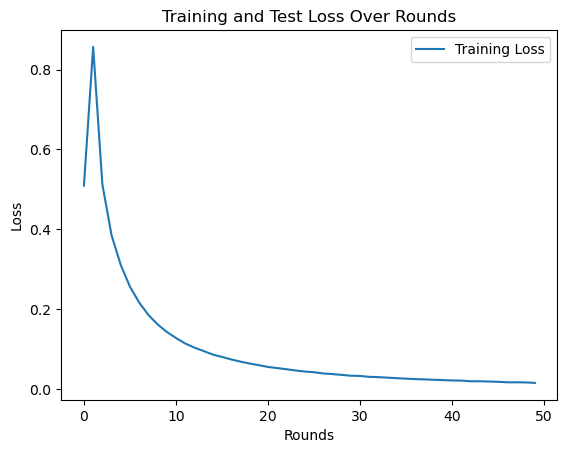

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_train, label='Training Loss')
#plt.plot(loss_test, label='Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Rounds')
plt.legend()
plt.show()

In [26]:
selected_clients

array([8, 6, 3, 2, 0, 7, 9, 1, 4, 5])

In [ ]:
# Plotting the graphs
def plot_graphs(train_accuracy, test_accuracy, train_loss, test_loss):
    plt.figure(1, figsize=(10,6))
    plt.plot(train_accuracy, label='Train Accuracy', color='red', linewidth=2)
    plt.plot(test_accuracy, label='Test Accuracy', color='blue', linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Epoch Accuracy Plot")
    plt.legend()
    #plt.savefig('acc'+'_'+str(learning_rate)+'_'+key+'_'+str(weight_decay)+'_'+str(batch_size)+'_'+str(xavier)+'.jpg', dpi=100, bbox_inches='tight')

    plt.figure(2, figsize=(10,6))
    plt.plot(train_loss, label='Train loss', color='r', linewidth=2)
    plt.plot(test_loss, label='Test loss', color='b', linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Epoch Loss Plot")
    plt.legend()

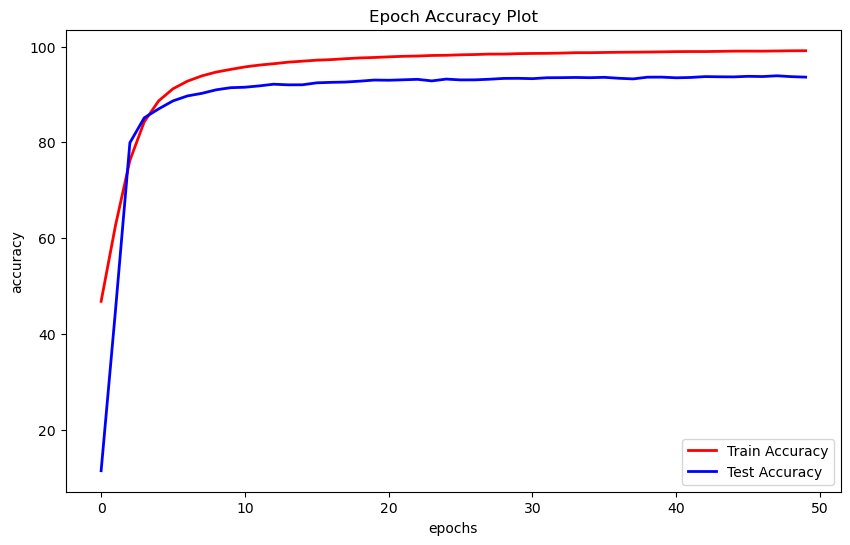

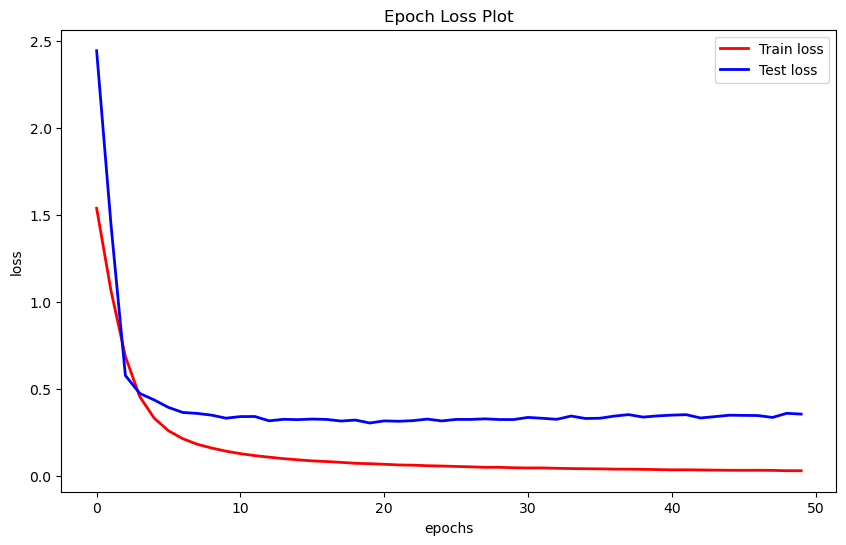

In [ ]:
plot_graphs(acc_train, acc_test, loss_train, loss_test)

In [29]:
with open('FL_model_resnet9_overfit_train_accuracy.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{acc_train}\n")

In [30]:
with open('FL_model_resnet9_overfit_test_accuracy.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{acc_test}\n")

In [31]:
with open('FL_model_resnet9_overfit_train_loss.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{loss_train}\n") 

In [32]:
with open('FL_model_resnet9_overfit_test_loss.txt', 'w') as file:
    # Write each value on a new line
    file.write(f"{loss_test}\n")

In [42]:
# import ast
# with open('test_accuracy.txt', 'r') as file:
#     loaded_t_acc = file.read()
# ast.literal_eval(loaded_t_acc)

In [ ]:
import os

model_path = '/content/drive/MyDrive/Colab Notebooks/FL_Base/global_model_weights_resnet18.pth'

# Initialize the model (make sure it has the same architecture as the saved weights)
loaded_model = ResNet18(
    in_channels=num_channels, num_classes=num_classes).to(device)

# Load model weights
loaded_model.load_state_dict(torch.load(model_path))
print(f'Model weights loaded from {model_path}')

In [33]:
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)

In [34]:
# Use one batch for the attack
images, labels = next(iter(testloader))

In [36]:
# Initialize dummy data
dummy_data = torch.randn_like(images, requires_grad=True, device=device)

# Define optimizer for the dummy data
optimizer = torch.optim.LBFGS([dummy_data], lr=0.01)

def closure():
    optimizer.zero_grad()
    dummy_outputs = global_model(dummy_data)
    dummy_loss = criterion(dummy_outputs, labels.to(device))
    dummy_loss.backward()
    return dummy_loss

# Optimize the dummy data
for it in range(300):  # Number of optimization iterations
    optimizer.step(closure)

    if it % 10 == 0:  # Print loss every 10 iterations
        current_loss = closure()
        print(f"Iteration {it}, Loss: {current_loss.item()}")

Iteration 0, Loss: 9.325345039367676
Iteration 10, Loss: 0.11462259292602539
Iteration 20, Loss: 0.00682041933760047
Iteration 30, Loss: 0.0005145419854670763
Iteration 40, Loss: 3.6379995435709134e-05
Iteration 50, Loss: 4.279410859453492e-06
Iteration 60, Loss: 4.279410859453492e-06
Iteration 70, Loss: 4.279410859453492e-06
Iteration 80, Loss: 4.279410859453492e-06
Iteration 90, Loss: 4.279410859453492e-06
Iteration 100, Loss: 4.279410859453492e-06
Iteration 110, Loss: 4.279410859453492e-06
Iteration 120, Loss: 4.279410859453492e-06
Iteration 130, Loss: 4.279410859453492e-06
Iteration 140, Loss: 4.279410859453492e-06
Iteration 150, Loss: 4.279410859453492e-06
Iteration 160, Loss: 4.279410859453492e-06
Iteration 170, Loss: 4.279410859453492e-06
Iteration 180, Loss: 4.279410859453492e-06
Iteration 190, Loss: 4.279410859453492e-06
Iteration 200, Loss: 4.279410859453492e-06
Iteration 210, Loss: 4.279410859453492e-06
Iteration 220, Loss: 4.279410859453492e-06
Iteration 230, Loss: 4.279410

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


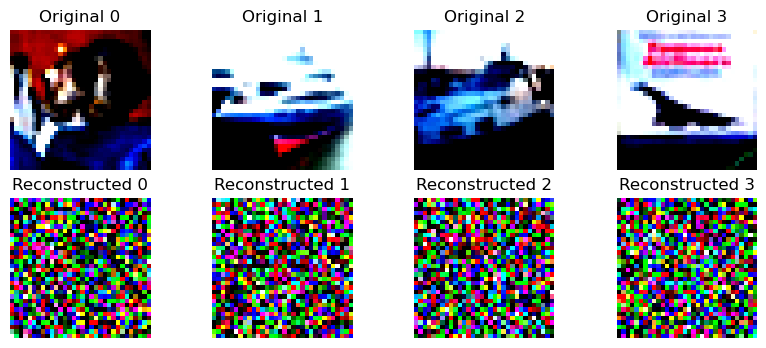

In [37]:
import matplotlib.pyplot as plt

# Move dummy data to CPU and remove gradients for visualization
reconstructed = dummy_data.detach().cpu()

# Visualize some original and reconstructed images
fig, axs = plt.subplots(2, 4, figsize=(10, 4))
for i in range(4):
    axs[0, i].imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
    axs[0, i].title.set_text(f"Original {i}")
    axs[0, i].axis('off')

    axs[1, i].imshow(np.transpose(reconstructed[i].numpy(), (1, 2, 0)))
    axs[1, i].title.set_text(f"Reconstructed {i}")
    axs[1, i].axis('off')
plt.show()

In [2]:
import ast
with open('test_loss.txt', 'r') as file:
    loaded_t_acc = file.read()
fl_loss = ast.literal_eval(loaded_t_acc)

In [3]:
import ast
with open('central_test_loss.txt', 'r') as file:
    loaded_t_acc = file.read()
centralized_loss = ast.literal_eval(loaded_t_acc)

In [4]:
import ast
with open('test_loss_ps.txt', 'r') as file:
    loaded_t_acc = file.read()
ps_loss = ast.literal_eval(loaded_t_acc)

In [9]:
import ast
with open('test_loss_ps_2.txt', 'r') as file:
    loaded_t_acc = file.read()
ps_loss_2 = ast.literal_eval(loaded_t_acc)

In [7]:
import matplotlib.pyplot as plt
from typing import List
def plot_ndcg(epochs: int, central_loss: List[float], fed_loss: List[float], ps_loss):
    """
    Plots training loss across epochs for two different models.
    
    :param epochs: Number of global training epochs
    :param loss1: List of loss per global epoch for the first model
    :param loss2: List of loss per global epoch for the second model
    :param num_clients: Number of clients sampled per epoch
    """
    plt.figure(figsize=(10, 6))
    plt.plot(list(range(epochs)), central_loss, label='Centralized Model', color="blue")
    plt.plot(list(range(epochs)), fed_loss, label='FL', color="red")
    plt.plot(list(range(epochs)), ps_loss, label='FL with partial Sharing', color="green")
    plt.ylim(0.0, 3.5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss per epoch')
    plt.legend()
    plt.show()

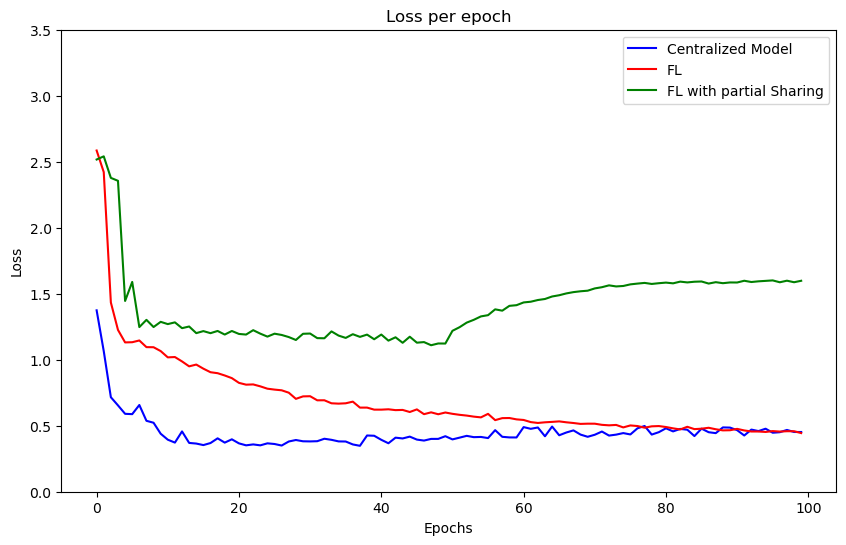

In [12]:
plot_ndcg(100, centralized_loss[:100], fl_loss[:100], ps_loss_2)